In [1]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString, Polygon # Geometry
from shapely.geometry import box, shape
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

In [2]:
# Load SegmentAnything
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
device = 'cuda:0'
sam.to(device)
print("SAM loaded")

SAM loaded


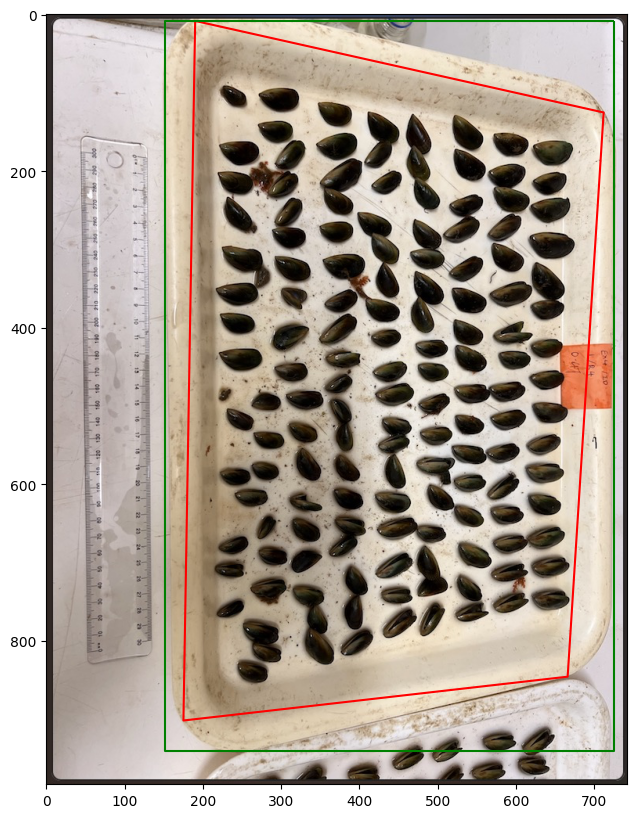

[[ 7.71693934e-01  4.00033953e-04 -5.33633167e+00]
 [-1.14264902e-01 -9.79087398e-01  9.10024367e+02]
 [-3.34754835e-04 -8.87150418e-05  1.00000000e+00]]


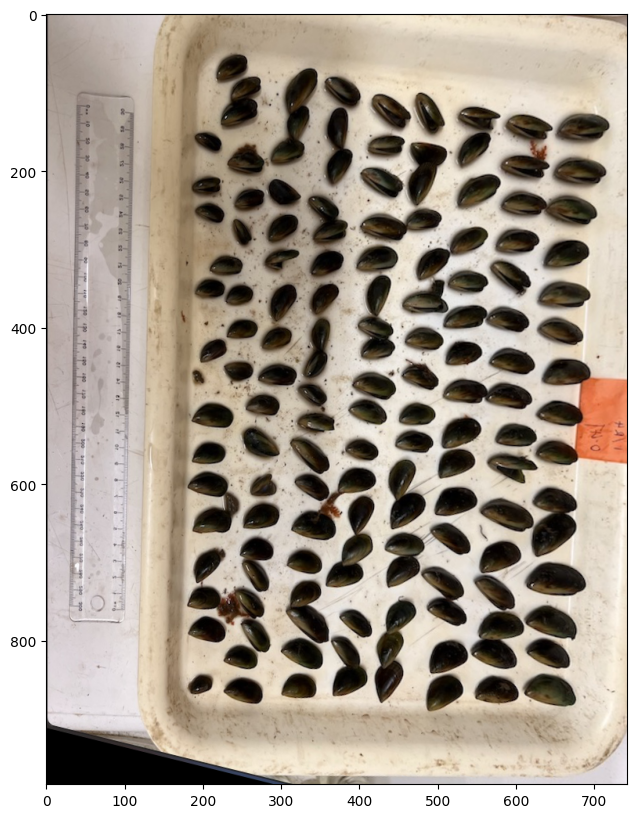

In [3]:
# Reproject trapezoidal tray to rectangular (rectify)
img = cv2.cvtColor(cv2.imread('test.png'), cv2.COLOR_BGR2RGB)
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
tray = max(masks, key=lambda x: x["area"])
# Convert binary mask to polygon
tray = shape(next(shapes(tray["segmentation"].astype(np.uint8), mask=tray["segmentation"]))[0])
plt.figure(figsize=(10,10))
plt.imshow(img)
trapezoid = tray.convex_hull.simplify(50).exterior
bounds = box(*tray.bounds).exterior
gpd.GeoSeries(trapezoid).plot(ax=plt.gca(), color="red")
gpd.GeoSeries(bounds).plot(ax=plt.gca(), color="green")
plt.show()
source_corners = np.float32(sorted(trapezoid.coords[:4]))
target_corners = np.float32(sorted(bounds.coords[:4]))
matrix = cv2.getPerspectiveTransform(source_corners, target_corners)
print(matrix)
img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
plt.figure(figsize=(10,10))
plt.imshow(img)

In [4]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50, # The number of points to be sampled along one side of the image
    pred_iou_thresh=0.88, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.95, # The amount to shift the cutoff when calculated the stability score.
    box_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks.
    crop_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
    crop_n_layers=0, #  If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
    crop_n_points_downscale_factor=1, # The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

206

In [5]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
full_mask = np.zeros_like(masks[0]["segmentation"]).astype(int)
for i in range(len(masks)):
   x, y = np.where(masks[i]['segmentation'])
   full_mask[x,y] = i + 1

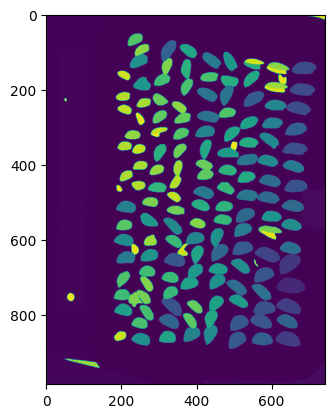

In [6]:
plt.imshow(full_mask)

In [7]:
# Vectorise raster
shape_gen = ((shape(s), v) for s, v in shapes(full_mask.astype(np.uint8), mask=full_mask>0))
# Convert shapes to GeoDataFrame, taking CRS from the image
df = gpd.GeoDataFrame(dict(zip(["geometry", "id"], zip(*shape_gen))))
df

geometry     id
0     POLYGON ((665.000 0.000, 665.000 1.000, 666.00...  194.0
1     POLYGON ((336.000 69.000, 336.000 70.000, 337....    9.0
2     POLYGON ((321.000 76.000, 321.000 77.000, 322....    9.0
3     POLYGON ((237.000 52.000, 251.000 52.000, 251....  151.0
4     POLYGON ((320.000 77.000, 320.000 78.000, 321....    9.0
...                                                 ...    ...
1033  POLYGON ((3.000 0.000, 152.000 0.000, 152.000 ...    2.0
1034  POLYGON ((49.000 917.000, 49.000 918.000, 53.0...  175.0
1035  POLYGON ((158.000 0.000, 627.000 0.000, 627.00...    1.0
1036  POLYGON ((0.000 905.000, 0.000 984.000, 307.00...    4.0
1037  POLYGON ((739.000 925.000, 741.000 925.000, 74...    6.0

[1038 rows x 2 columns]

<Axes: >

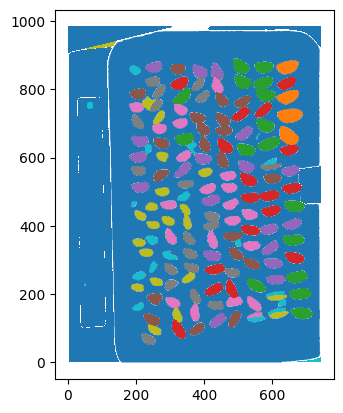

In [8]:
df.plot(column="id", categorical=True)

In [9]:
df["area"] = df.area

<Axes: >

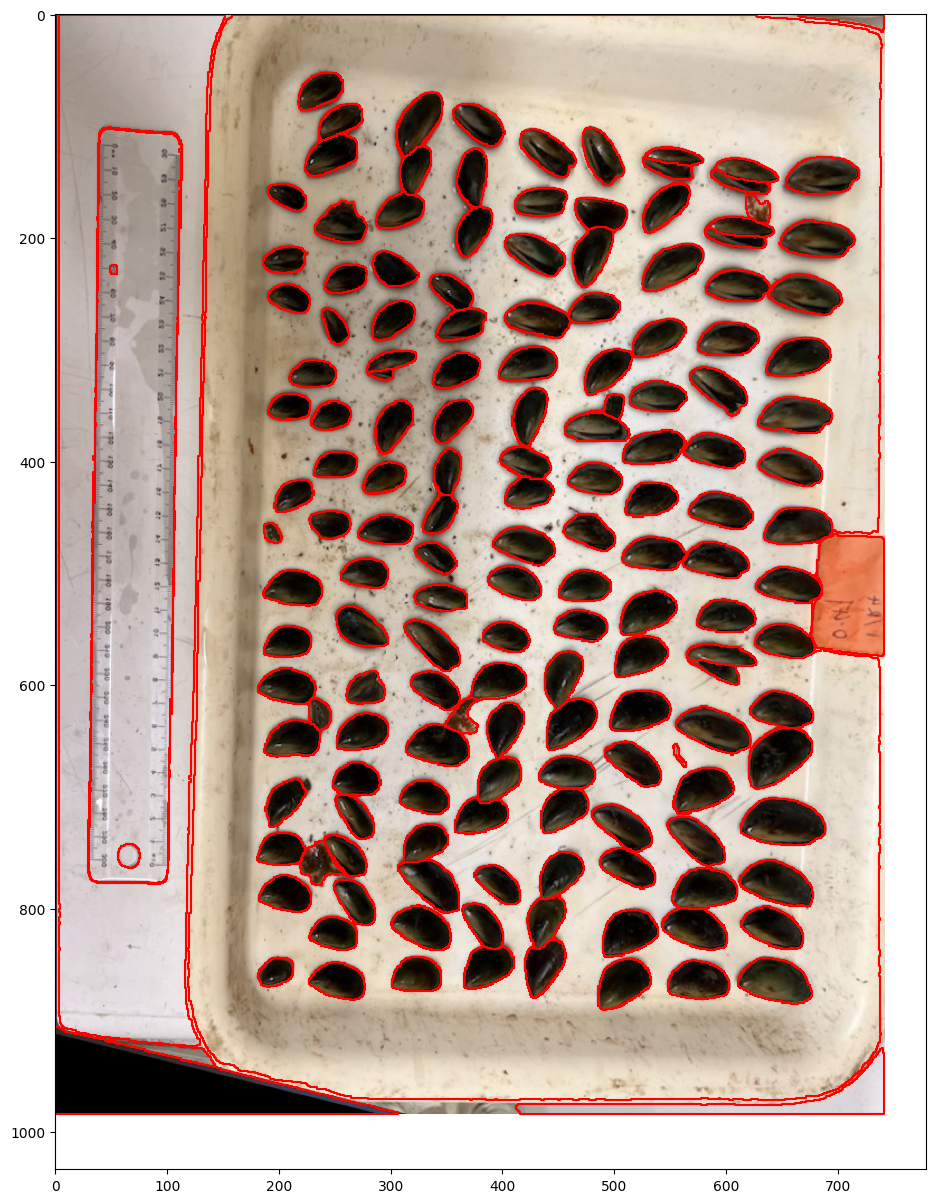

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(img)
df.boundary.plot(color="red", ax=plt.gca())

In [11]:
df = df.sort_values(by="area", ascending=False)
df

geometry    id      area
1035  POLYGON ((158.000 0.000, 627.000 0.000, 627.00...   1.0  408595.0
1033  POLYGON ((3.000 0.000, 152.000 0.000, 152.000 ...   2.0   64825.0
827   POLYGON ((44.000 102.000, 53.000 102.000, 53.0...   3.0   47693.0
1036  POLYGON ((0.000 905.000, 0.000 984.000, 307.00...   4.0   11998.0
581   POLYGON ((696.000 465.000, 700.000 465.000, 70...   5.0    6310.0
...                                                 ...   ...       ...
103   POLYGON ((328.000 150.000, 328.000 151.000, 32...  40.0       1.0
100   POLYGON ((329.000 148.000, 329.000 149.000, 33...  40.0       1.0
484   POLYGON ((340.000 421.000, 340.000 422.000, 34...  61.0       1.0
485   POLYGON ((357.000 422.000, 357.000 423.000, 35...  61.0       1.0
519   POLYGON ((595.000 473.000, 595.000 474.000, 59...  17.0       1.0

[1038 rows x 3 columns]

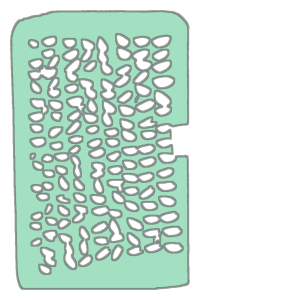

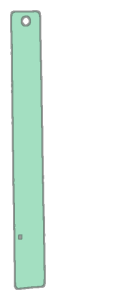

In [12]:
# Tray is largest, then the desk, then the ruler
tray = df.iloc[0]
display(tray.geometry)
ruler = df.iloc[2]
display(ruler.geometry)

In [13]:
ruler

geometry    POLYGON ((44 102, 53 102, 53 103, 63 103, 63 1...
id                                                        3.0
area                                                  47693.0
Name: 827, dtype: object

In [14]:
x1, y1, x2, y2 = ruler.geometry.bounds
ruler_height = y2 - y1
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

21.09375

In [15]:
df["centroid"] = df.centroid

In [16]:
df.iloc[0].centroid.coords[0]

(424.37879685262914, 478.2737319350457)

0it [00:00, ?it/s]

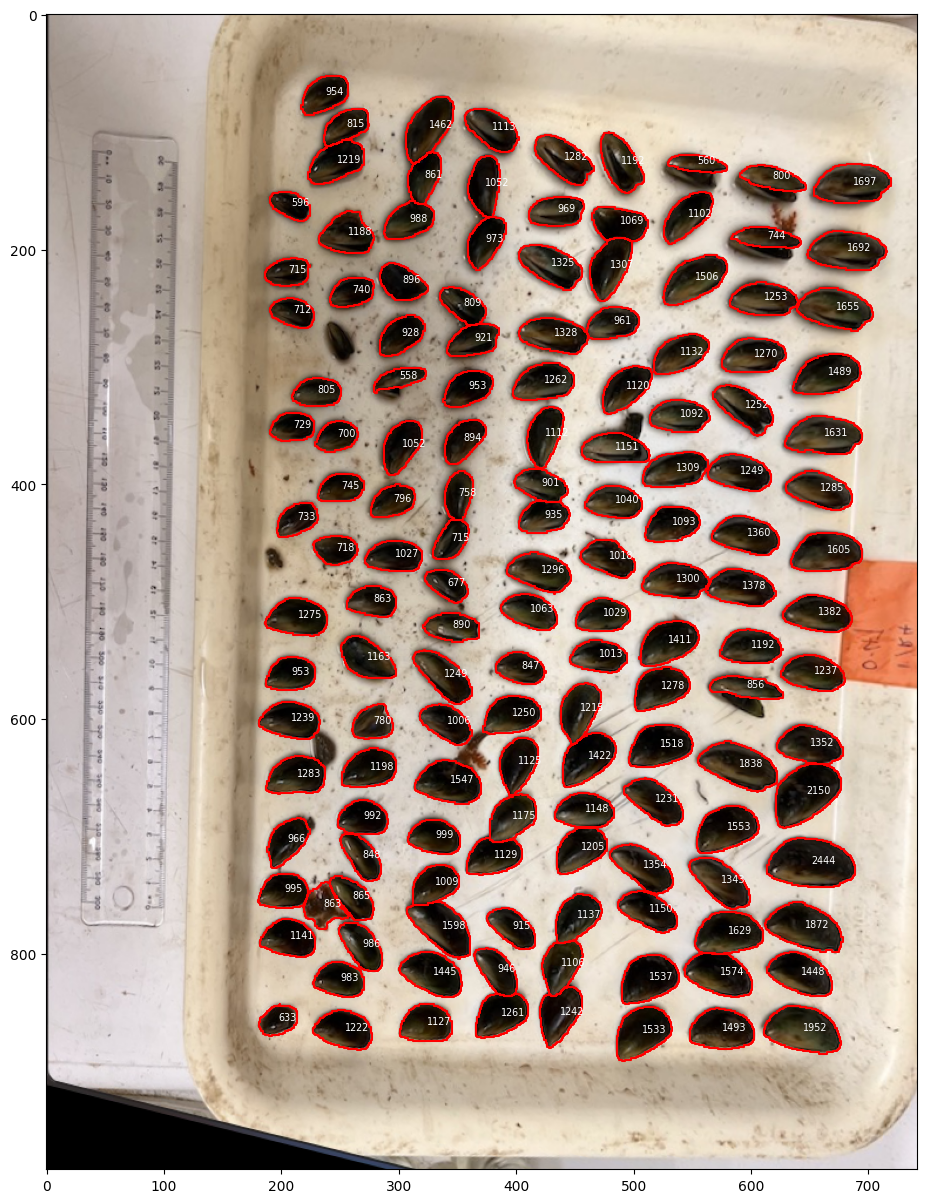

In [17]:
# Filter to just shapes in the tray
df = df[df.within(box(*tray.geometry.bounds).buffer(-5)) & (df.area > 550)]
plt.figure(figsize=(15,15))
plt.imshow(img)
df.boundary.plot(ax=plt.gca(), color="red")
for i, row in tqdm(df.iterrows()):
  plt.annotate(round(row.area), row.centroid.coords[0], color="white", fontsize="x-small")

In [18]:
df

geometry     id    area   
767   POLYGON ((638.000 701.000, 646.000 701.000, 64...   24.0  2444.0  \
691   POLYGON ((649.000 638.000, 662.000 638.000, 66...   33.0  2150.0   
1022  POLYGON ((630.000 844.000, 642.000 844.000, 64...   36.0  1952.0   
868   POLYGON ((635.000 756.000, 644.000 756.000, 64...   38.0  1872.0   
669   POLYGON ((577.000 619.000, 583.000 619.000, 58...   42.0  1838.0   
...                                                 ...    ...     ...   
532   POLYGON ((330.000 473.000, 342.000 473.000, 34...  189.0   677.0   
1003  POLYGON ((198.000 843.000, 199.000 843.000, 19...  190.0   633.0   
152   POLYGON ((197.000 151.000, 208.000 151.000, 20...  191.0   596.0   
77    POLYGON ((538.000 119.000, 556.000 119.000, 55...  192.0   560.0   
327   POLYGON ((301.000 301.000, 319.000 301.000, 31...  187.0   558.0   

                     centroid  
767   POINT (651.373 723.229)  
691   POINT (646.812 663.507)  
1022  POINT (644.627 864.999)  
868   POINT (646.408 777.585)  
669   POINT (590.161 639.910)  
...                       ...  
532   POINT (341.355 485.699)  
1003  POINT (197.522 856.655)  
152   POINT (208.045 162.539)  
77    POINT (554.214 126.798)  
327   POINT (300.708 309.783)  

[143 rows x 4 columns]

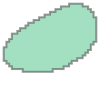

In [19]:
sample = df.sample(1)
poly = sample.geometry.iloc[0]
poly

In [20]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for a in coords:
        for b in coords:
            dist = a.distance(b)
            if dist > max_dist:
                max_dist = dist
                result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (223 173, 190 155)>, 37.589892258425)

Text(206.5, 164.0, '37.59px')

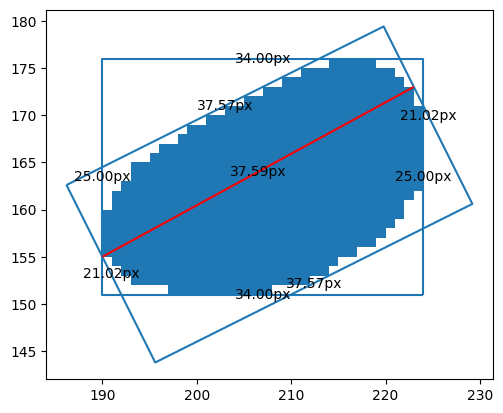

In [21]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = box(*poly.bounds)
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [22]:
df["diameter_line"] = df.geometry.progress_apply(get_diameter)
df["diameter_line"]

  0%|          | 0/143 [00:00<?, ?it/s]

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


767     LINESTRING (689.000 733.000, 614.000 724.000)
691     LINESTRING (674.000 645.000, 623.000 690.000)
1022    LINESTRING (677.000 878.000, 611.000 864.000)
868     LINESTRING (677.000 794.000, 612.000 774.000)
669     LINESTRING (622.000 654.000, 555.000 633.000)
                            ...                      
532     LINESTRING (359.000 493.000, 322.000 478.000)
1003    LINESTRING (212.000 847.000, 184.000 868.000)
152     LINESTRING (223.000 173.000, 190.000 155.000)
77      LINESTRING (580.000 132.000, 529.000 125.000)
327     LINESTRING (323.000 303.000, 279.000 321.000)
Name: diameter_line, Length: 143, dtype: geometry

In [23]:
ruler.diameter_line = get_diameter(ruler.geometry)

  0%|          | 0/143 [00:00<?, ?it/s]

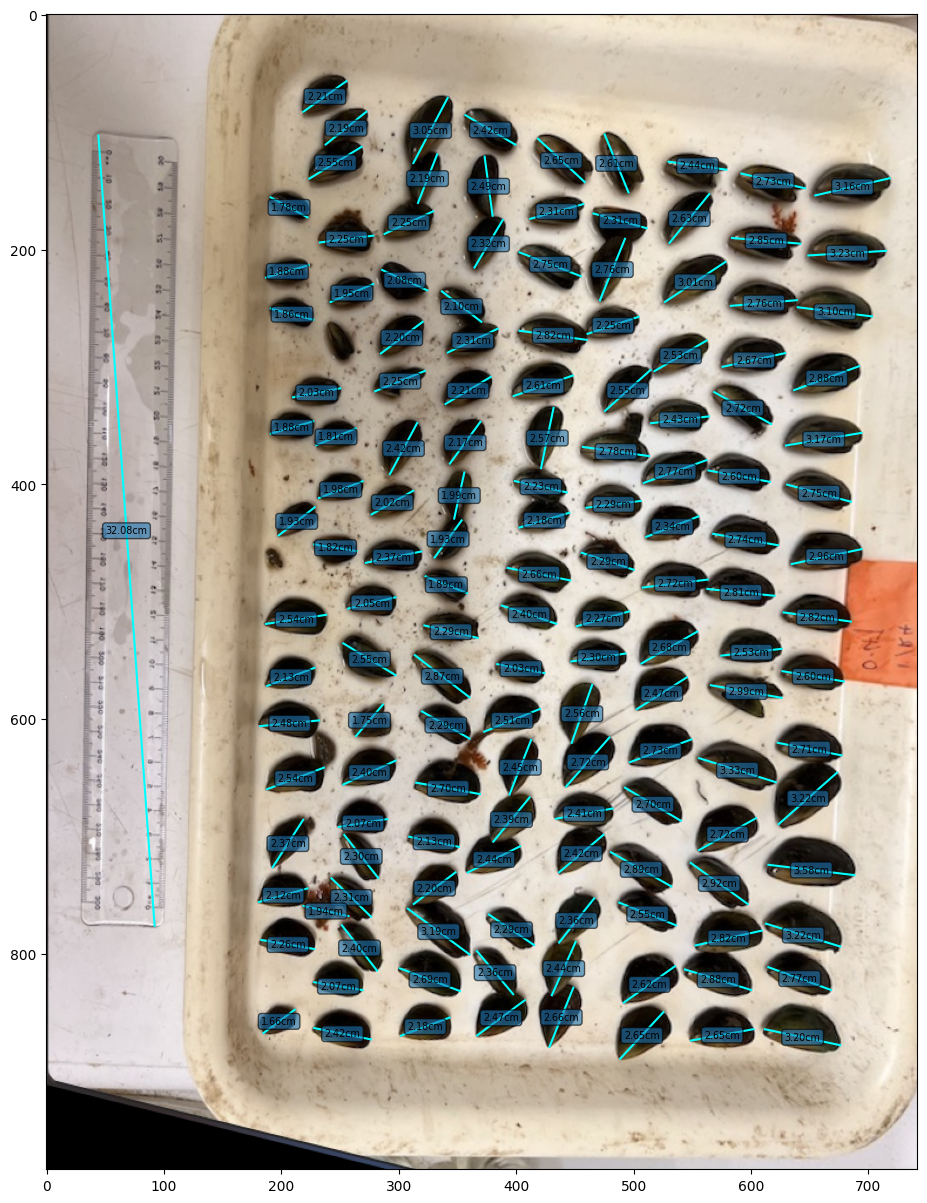

In [24]:
def annotate_length(line):
    gpd.GeoSeries(line).plot(color="cyan", ax=plt.gca())
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.figure(figsize=(15,15))
plt.imshow(img)
annotate_length(ruler.diameter_line)
for line in tqdm(df.diameter_line):
    annotate_length(line)

In [25]:
df["length_cm"] = df.diameter_line.length / px_per_cm
df.length_cm.describe()

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


count    143.000000
mean       2.475465
std        0.367654
min        1.659259
25%        2.238953
50%        2.440446
75%        2.718598
max        3.581064
Name: length_cm, dtype: float64